In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2

In [2]:
import sys

In [3]:
sys.argv = ['-f', 'fewdetv2', '--exp_id', 'coco_dla','--num_workers', '0','--batch_size','1', '--arch','dlav2_34'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [1]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\fewdetv2\coco_dla
fewdetv2
0
1


In [4]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [5]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'ss': 80, 'hm': 1, 'wh': 2, 'reg': 2}


In [6]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

In [7]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [8]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=14.45s)
creating index...
index created!
Loaded train 118287 samples


In [10]:
img = next(iter(train_loader))

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

In [107]:
(img['hm'][0] == 1).nonzero(as_tuple=False)

tensor([[ 0, 68, 29],
        [24, 87, 74],
        [41, 73, 83],
        [45, 69, 87],
        [47, 69, 87],
        [47, 70, 72],
        [47, 70, 88],
        [47, 72, 75],
        [47, 72, 78],
        [47, 73, 74],
        [47, 74, 67],
        [47, 74, 68],
        [47, 74, 77],
        [49, 67, 86],
        [49, 68, 83],
        [49, 68, 90],
        [49, 69, 84],
        [49, 69, 85],
        [49, 72, 70],
        [49, 72, 75],
        [49, 75, 72],
        [58, 46, 75],
        [58, 62, 80],
        [68, 58, 11],
        [72, 65,  0],
        [75, 69, 79]])

In [109]:
img['hm'][0][0,68,29]

tensor(1.)

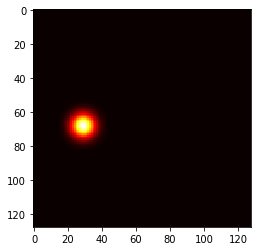

In [108]:
plt.imshow(img['hm'][0][0], cmap='hot', interpolation='nearest')

In [80]:
torch.max(img['hm'][0][0])

tensor(1.)

In [17]:
img['hm'][0][1].size()

torch.Size([128, 128])

In [19]:
img['img_path'][0] #lib\\..\\..\\data\\coco\\train2017\\000000024030.jpg'
num_objs = img['num_objs'][0]
ann_ids = img['ann_ids'][0]
anns = img['anns'][0]

In [36]:
img['img_path'][0]

'C:\\Users\\avata\\FewShot-CenterNet\\src\\lib\\..\\..\\data\\coco\\train2017\\000000024030.jpg'

In [54]:
Dataset(opt,'train')

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=17.62s)
creating index...
index created!
Loaded train 118287 samples


<datasets.dataset_factory.get_dataset.<locals>.Dataset at 0x2cba2d0c988>

In [15]:
Dataset.__getitem__(opt, 0)

AttributeError: 'Namespace' object has no attribute 'images'

In [69]:
Dataset.__getitem__(opt,'C:\\Users\\avata\\FewShot-CenterNet\\src\\lib\\..\\..\\data\\coco\\train2017\\000000024030.jpg')

AttributeError: 'Namespace' object has no attribute 'images'

In [40]:
ann_ids

tensor([99117])

In [24]:
num_objs

tensor(18)

In [28]:
opt.debug 

0

In [14]:
import torch.utils.data as data
import numpy as np
import torch
import json
import cv2
import os
from utils.image import flip, color_aug
from utils.image import get_affine_transform, affine_transform
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.image import draw_dense_reg
import math